### Benson Challenges

Note: Challenges should be solved using pandas. If you are looking for extra work, you're welcome to take a stab at solving them using only python dictionaries, but this is harder and avoiding this is the entire point of pandas!


#### Challenge 1   
  
- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Read them into a pandas dataframe (pd.read_csv()), format the columns nicely, and display the first few rows.   

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [84]:
# Source: http://web.mta.info/developers/turnstile.html

def get_data(dates):
    link = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    data = []
    for date in dates:
        file_link = link.format(date)
        data.append(pd.read_csv(file_link))
    return pd.concat(data)
        
dates = [180922, 180915, 180908]
df = get_data(dates)

In [86]:
# Removing blank spaces in namea
df.columns = [column.strip() for column in df.columns]
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,00:00:00,REGULAR,6759219,2291425
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,04:00:00,REGULAR,6759234,2291429
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,08:00:00,REGULAR,6759251,2291453
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,12:00:00,REGULAR,6759330,2291532
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,16:00:00,REGULAR,6759538,2291574


#### Challenge 2

- Let's turn this into a time series.

Create a new column that stores the date and time as a single pandas datetime object.

In [87]:
df['DATETIME'] = pd.to_datetime(df['DATE'].apply(str)+" "+df['TIME'])

In [88]:
# For later use 
df['DATE'] = pd.to_datetime(df['DATE'],format="%m/%d/%Y")
df['Day of the Week'] = df['DATE'].dt.day_name()
df['Week #'] = df['DATE'].dt.week

#### Challenge 3

- These counts are for every n hours (What is n?). Also, there's something odd about these "counts", what is it? 
Do they actually represent total entries for a time period, or something else? We want total daily entries, create a new dataframe with one row per turnstile/day and a column that gives total daily entries.

In [89]:
# Clean intermediate hours
def bucket_time(time):
    timelist = [1,2,3,4,5,6,7]
    if time > '20:00:00':
        bucket = '00:00:00'
    elif time > '16:00:00':
        bucket = '20:00:00'
    elif time >'12:00:00':
        bucket= '16:00:00'
    elif time > '08:00:00':
        bucket = '12:00:00'
    elif time > '04:00:00':
        bucket = '08:00:00'
    else:
        bucket = '04:00:00'
    return bucket
    
df['Time Bucket'] = df['TIME'].apply(lambda x:bucket_time(x))

In [90]:
# Creating unique turnstile variables
df['TURNSTILE'] = df['C/A']+df['UNIT']+df['SCP']+df['STATION']

In [91]:
# Calculating the actual number of entries (as the difference)
df=df.sort_values(by=['TURNSTILE','DATETIME'])
df['ENTRIES_COUNT']=abs(df['ENTRIES'].diff()) #abs value to take turnstiles that ran in reverse

#get rid of initial time differences
df['FIRST'] = df.groupby('TURNSTILE').cumcount()
df = df[df['FIRST'] != 0]

#get rid of extreme values
df = df[abs(df['ENTRIES_COUNT']) < 10000]

In [92]:
Total_Daily=df.groupby(['TURNSTILE','DATE'])['ENTRIES_COUNT'].sum().reset_index()
Total_Daily.head()

,TURNSTILE,DATE,ENTRIES_COUNT
0,A002R05102-00-0059 ST,2018-09-01,571.0
1,A002R05102-00-0059 ST,2018-09-02,564.0
2,A002R05102-00-0059 ST,2018-09-03,595.0
3,A002R05102-00-0059 ST,2018-09-04,1202.0
4,A002R05102-00-0059 ST,2018-09-05,1406.0


#### Challenge 4

We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:

    %matplotlib inline

This will make your matplotlib graphs integrate nicely with the
notebook. To plot the time series, import matplotlib with

    import matplotlib.pyplot as plt

Extract a list of dates and a list of counts from the dataframe, 
dates and counts. This should plot it:

    plt.figure(figsize=(10,3))
    plt.plot(dates,counts)




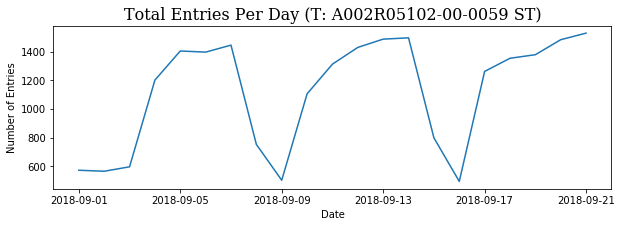

In [93]:
dates = Total_Daily[Total_Daily['TURNSTILE'] =='A002R05102-00-0059 ST']['DATE']
counts = Total_Daily[Total_Daily['TURNSTILE'] =='A002R05102-00-0059 ST']['ENTRIES_COUNT']

plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.title('Total Entries Per Day (T: A002R05102-00-0059 ST)',family='serif',fontsize = 16,color='k');
plt.xlabel('Date');
plt.ylabel('Number of Entries');
plt.show()

#### Challenge 5

- So far we've been operating on a single turnstile level, let's
  combine turnstiles in the same ControlArea/Unit/Station combo. There
  are some ControlArea/Unit/Station groups that have a single
  turnstile, but most have multiple turnstilea-- same value for the
  C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each
ControlArea/UNIT/STATION combo, for each day, add the counts from each
turnstile belonging to that combo.




In [94]:
ca_u_s = df.groupby(['C/A','UNIT','STATION','DATE'])['ENTRIES_COUNT'].sum().reset_index()
ca_u_s.head()

,C/A,UNIT,STATION,DATE,ENTRIES_COUNT
0,A002,R051,59 ST,2018-09-01,6095.0
1,A002,R051,59 ST,2018-09-02,6353.0
2,A002,R051,59 ST,2018-09-03,5988.0
3,A002,R051,59 ST,2018-09-04,11313.0
4,A002,R051,59 ST,2018-09-05,12635.0


#### Challenge 6

Similarly, combine everything in each station, and come up with a time
series of `[(date1, count1),(date2,count2),...]` type of time series
for each STATION, by adding up all the turnstiles in a station.




In [125]:
station = df.groupby(['STATION','DATE'])['ENTRIES_COUNT'].sum().reset_index()

#### Challenge 7

Plot the time series for a station.




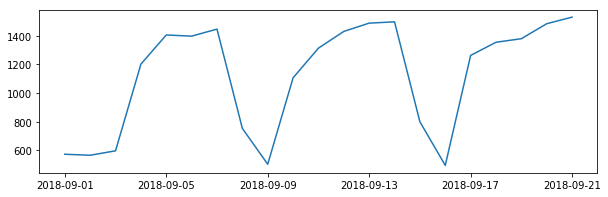

In [103]:
station_1 = station[station['STATION']=='1 AV']
s_dates = station_1['DATE']
s_counts = station_1['ENTRIES_COUNT']

plt.figure(figsize=(10,3))
plt.plot(s_dates,counts)

#### Challenge 8

- Make one list of counts for **one** week for one station. Monday's
count, Tuesday's count, etc. so it's a list of 7 counts.
Make the same list for another week, and another week, and another
week.
`plt.plot(week_count_list)` for every `week_count_list` you created
this way. You should get a rainbow plot of weekly commute numbers on
top of each other.




In [104]:
station_1['Day of the Week'] = station_1['DATE'].dt.day_name()
station_1['Week #'] = station_1['DATE'].dt.week

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


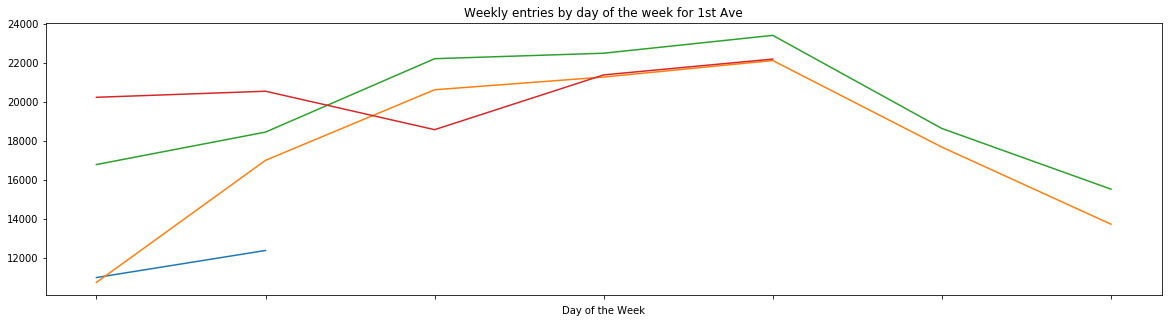

In [101]:
fig,ax = plt.subplots(figsize=(20,5))
plots = station_1.groupby('Week #').plot(y='ENTRIES_COUNT',x='Day of the Week',ax=ax,legend=False, title='Weekly entries by day of the week for 1st Ave')

#### Challenge 9

- Over multiple weeks, sum total ridership for each station and sort
  them, so you can find out the stations with the highest traffic
  during the time you investigate




In [106]:
df.groupby('STATION')['ENTRIES_COUNT'].sum().sort_values(ascending=False).head(10)

STATION
34 ST-PENN STA     2892409.0
GRD CNTRL-42 ST    2568599.0
34 ST-HERALD SQ    2151627.0
14 ST-UNION SQ     1883574.0
TIMES SQ-42 ST     1865617.0
42 ST-PORT AUTH    1850513.0
23 ST              1839072.0
FULTON ST          1728829.0
CANAL ST           1461429.0
125 ST             1425651.0
Name: ENTRIES_COUNT, dtype: float64

#### Challenge 10

- Make a single list of these total ridership values and plot it with

    plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among
different stations.

This should show you that most stations have a small traffic, and the
histogram bins for large traffic volumes have small bars.

*Additional Hint*:

If you want to see which stations take the meat of the traffic, you
can sort the total ridership counts and make a `plt.bar` graph. For
this, you want to have two lists: the indices of each bar, and the
values. The indices can just be `0,1,2,3,...`, so you can do

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

Text(0.5, 1.0, 'Total ridership per station')

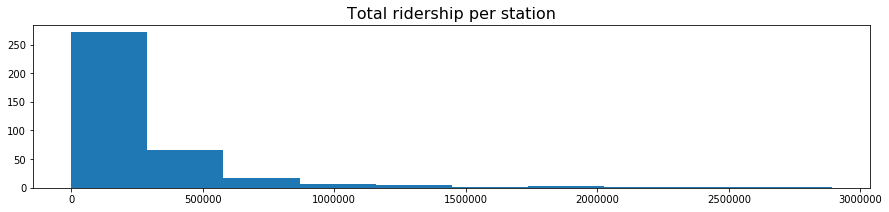

In [120]:
total_ridership_counts=df.groupby('STATION')['ENTRIES_COUNT'].sum().sort_values(ascending=False)

plt.figure(figsize=(15,3))
plt.hist(total_ridership_counts)
plt.title('Total ridership per station',fontsize=16)

<BarContainer object of 374 artists>

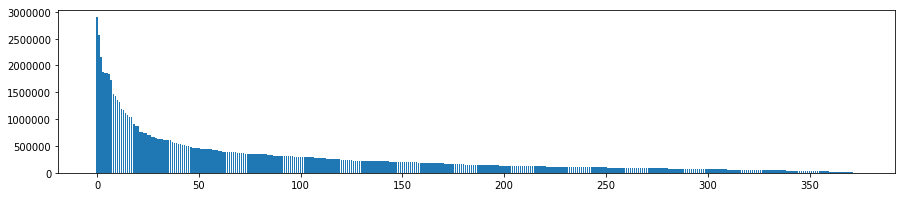

In [116]:
plt.figure(figsize=(15,3))
indices = range(len(total_ridership_counts.values))
plt.bar(indices, total_ridership_counts.values)

Text(0.5, 1.0, 'Entries by station (Top 40)')

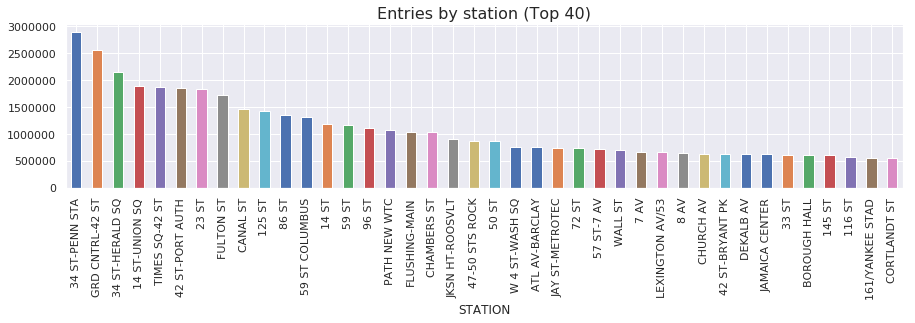

In [123]:
sns.set()
plt.figure(figsize = (15,3))
total_ridership_counts.iloc[0:40].plot.bar()
plt.title('Entries by station (Top 40)',fontsize=16)

In [124]:
# Old
dates = ["180922.txt","180915.txt","180908.txt"]
data = []
df = pd.DataFrame()
for date in dates:
    link = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_" + date
    data.append(pd.read_csv(link))
df = pd.concat(data)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-124-60ad777cf0e7>, line 8)